In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Time of Flight measurement

In [3]:
def load_dataset(filename, which_channels = ["0_8","0_20"], noise_reject_rate = 0.01):
    """
    Load DT5550W DAQ dataset (processing mode = "FULL")
    
    Inputs
    -------
    filename: str
        Filename path
    which_channels: list or "auto"
        If which_channels is list, read the sepcified channels
        If which_channels is "auto", find active channels 
        If which_channels is "all", load the whole dataset
    noise_reject_rate: float in [0,1]
        The percentage of events needed to be identified as active channels, required only when which_channels is "auto"
        
    Returns
    -------
    df: Pandas dataframe
    """
    if which_channels == "all":
        return pd.read_csv(filename, sep=';', error_bad_lines = False,warn_bad_lines=True)
    cols_list = pd.read_csv(filename, nrows=0).columns.tolist()[0].split(sep=";")
    #metadata_name = cols_list[:10]+cols_list[int(len(cols_list)/2+2):int(len(cols_list)/2+8)]
    metadata_name = cols_list[:10]
    #dtype_list = ["HIT_","CHARGE_", "COARSE_", "FINE_","RELATIVETIME_"]
    dtype_list = ["HIT_","CHARGE_", "COARSE_", "FINE_",]
    if which_channels == "auto":
        ch_hit =[]
        for i in range(32):
            ch_hit.append("HIT_0_{0}".format(i))
            ch_hit.append("HIT_1_{0}".format(i))
        hit_df = pd.read_csv(filename, sep=';', error_bad_lines = False,warn_bad_lines=True, usecols=ch_hit).fillna(0).to_numpy()
        ch_list = np.argwhere(np.sum(hit_df, axis = 0) > noise_reject_rate*len(hit_df))
        which_channels = []
        for index in ch_list:
            if index >= 32:
                which_channels.append("1_{0}".format(index[0]-32))
            else:
                which_channels.append("0_{0}".format(index[0]))
    data_ch = []
    for channels in which_channels:
        for ch_name in dtype_list:
            data_ch.append(ch_name+channels)
    return pd.read_csv(filename, sep=';', error_bad_lines = False,warn_bad_lines=True, usecols=metadata_name+data_ch)

def find_alpha(df, channels = ['FINE_0_8', 'FINE_0_26']):
    alpha = np.zeros(len(channels))
    for i,ch in enumerate(channels):
        alpha[i] = 25/(np.max(df[ch])-np.min(df[ch]))
    return alpha

In [118]:
filename = "1121_1.data"
df = load_dataset(filename, which_channels = "auto", noise_reject_rate = 0.01).to_dict('list')

/tmp/ipykernel_161108/2479681061.py:2: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  df = load_dataset(filename, which_channels = "auto", noise_reject_rate = 0.01).to_dict('list')
/tmp/ipykernel_161108/2479681061.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  df = load_dataset(filename, which_channels = "auto", noise_reject_rate = 0.01).to_dict('list')


In [119]:
df.keys()

dict_keys(['ID_CLUSTER', 'CLUSTER_RUN_Timecode_ns', 'CLUSTER_Timecode_ns', 'NEventsInCluster', 'ASIC_0', 'EventCounter_0', 'RUN_EventTimeCodeLSB_0', 'RUN_EventTimecode_ns_0', 'T0_to_Event_Timecode_0', 'T0_to_Event_Timecode_ns_0', 'HIT_0_8', 'HIT_0_26', 'CHARGE_0_8', 'CHARGE_0_26', 'COARSE_0_8', 'COARSE_0_26', 'FINE_0_8', 'FINE_0_26'])

In [131]:
np.array([df['FINE_0_8'],df['FINE_0_26']]).T

array([[539, 361],
       [589, 539],
       [891, 723],
       ...,
       [749, 470],
       [675, 630],
       [958, 794]])

In [133]:
alpha

array([0.03654971, 0.03654971])

In [137]:
alpha = find_alpha(df, channels = ['FINE_0_8', 'FINE_0_26'])
fine_time = np.multiply(alpha,np.array([df['FINE_0_8']-np.min(df['FINE_0_8']),df['FINE_0_26']-np.min(df['FINE_0_26'])]).T)
coarse_time = np.array([df['COARSE_0_8'],df['COARSE_0_26']])*25

In [151]:
time = (coarse_time-fine_time.T)
ToF = time[1]-time[0]

Text(0, 0.5, 'counts')

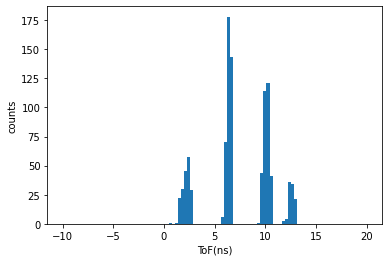

In [153]:
plt.hist(ToF,bins = 100, range = (-10,20))
plt.xlabel("ToF(ns)")
plt.ylabel("counts")

In [121]:
load_dataset(filename, which_channels = "auto", noise_reject_rate = 0.01)

/tmp/ipykernel_161108/750095076.py:1: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  load_dataset(filename, which_channels = "auto", noise_reject_rate = 0.01)
/tmp/ipykernel_161108/750095076.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  load_dataset(filename, which_channels = "auto", noise_reject_rate = 0.01)


,ID_CLUSTER,CLUSTER_RUN_Timecode_ns,CLUSTER_Timecode_ns,NEventsInCluster,ASIC_0,EventCounter_0,RUN_EventTimeCodeLSB_0,RUN_EventTimecode_ns_0,T0_to_Event_Timecode_0,T0_to_Event_Timecode_ns_0,HIT_0_8,HIT_0_26,CHARGE_0_8,CHARGE_0_26,COARSE_0_8,COARSE_0_26,FINE_0_8,FINE_0_26
0,1,7805600,70440750,1,0,0,312224,7805600,2817630,70440750,1,1,149,209,414,414,539,361
1,2,17806300,150446350,1,0,1,712252,17806300,6017854,150446350,1,1,153,218,58,58,589,539
2,3,27806975,230451850,1,0,2,1112279,27806975,9218074,230451850,1,1,153,209,214,214,891,723
3,4,37807675,310457400,1,0,3,1512307,37807675,12418296,310457400,1,1,159,207,369,370,376,892
4,5,47808375,390462950,1,0,4,1912335,47808375,15618518,390462950,1,1,149,202,13,13,557,382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,1001,11118576425,8425970600,1,0,1111,444743057,11118576425,337038824,8425970600,1,1,148,205,399,400,424,842
1001,1002,11128577125,8505976200,1,0,1112,445143085,11128577125,340239048,8505976200,1,1,163,201,43,43,353,309
1002,1003,11138577800,8585981700,1,0,1113,445543112,11138577800,343439268,8585981700,1,1,163,199,199,199,749,470
1003,1004,11148578500,8665987300,1,0,1114,445943140,11148578500,346639492,8665987300,1,1,138,221,355,355,675,630
